<center><img src='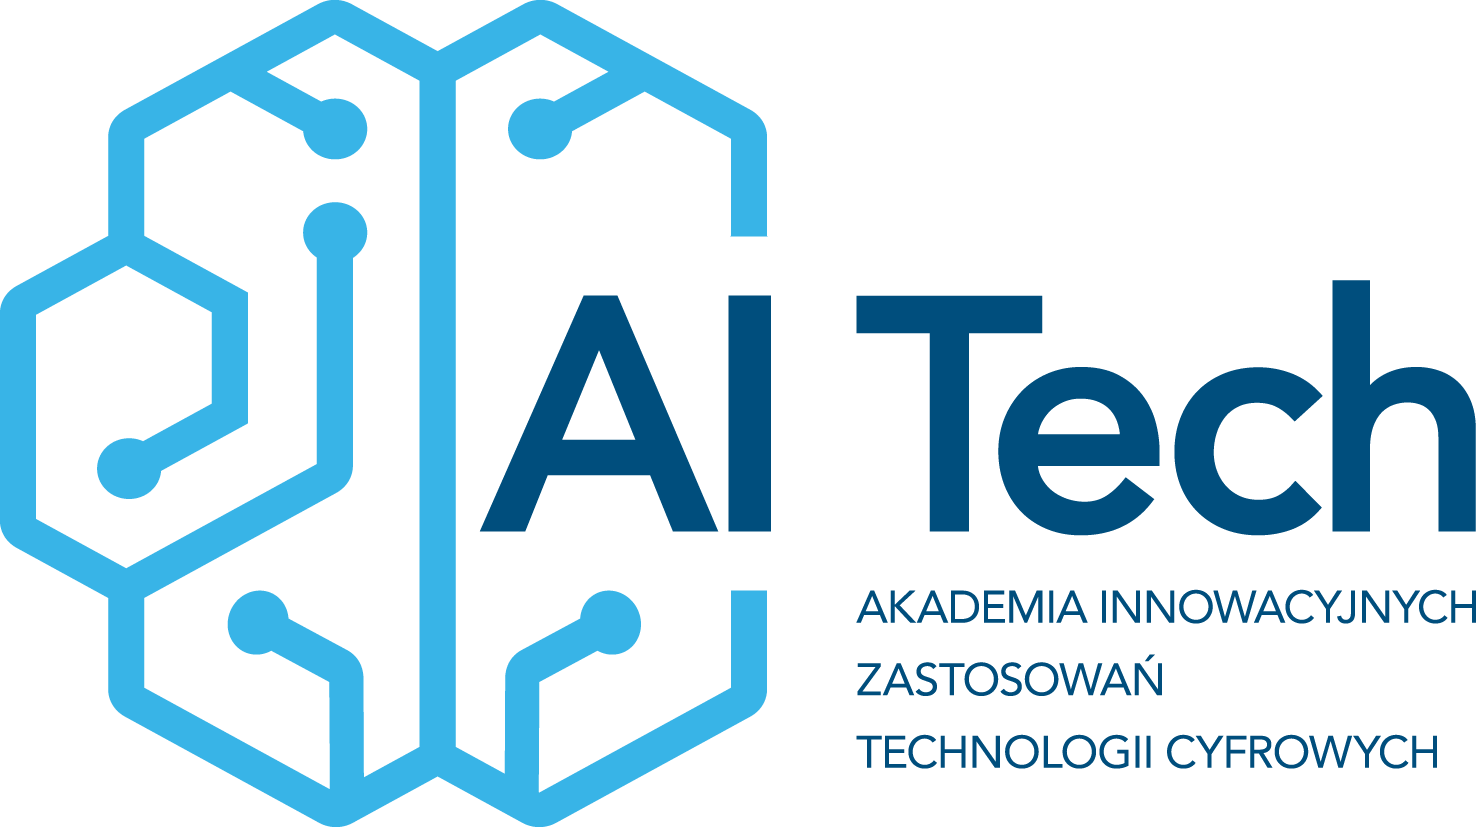
' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center>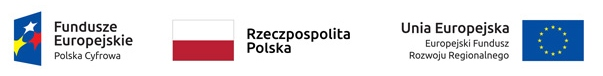</center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego 
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej" 
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

**Author: Jacek Sroka**




# ML in big scale - LAB 11




Hyperparameter tuning

* Grid search in Spark
* Optuna
* Distributing Optuna

## PySpark

### Pyspark installation

In [2]:
!pip install pyspark --quiet
!pip install pyspark[pandas_on_spark] plotly --quiet
!apt install openjdk-8-jdk-headless &> /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

from pyspark.sql import SparkSession
spark = SparkSession.builder \
                    .master("local[*]") \
                    .appName("mlibs") \
                    .getOrCreate()

from pyspark import SparkContext
sc = spark.sparkContext

### PySpark Linear regression

Example from [docs](https://spark.apache.org/docs/latest/ml-classification-regression.html#linear-regression). Read more [here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.LinearRegression.html#pyspark.ml.regression.LinearRegression).

In [3]:
from pyspark.ml.regression import LinearRegression

# Load training data
training = spark.read.format("libsvm")\
    .load("/usr/local/lib/python3.8/dist-packages/pyspark/data/mllib/sample_linear_regression_data.txt")

training.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



In [4]:
training.take(5)

[Row(label=-9.490009878824548, features=SparseVector(10, {0: 0.4551, 1: 0.3664, 2: -0.3826, 3: -0.4458, 4: 0.3311, 5: 0.8067, 6: -0.2624, 7: -0.4485, 8: -0.0727, 9: 0.5658})),
 Row(label=0.2577820163584905, features=SparseVector(10, {0: 0.8387, 1: -0.127, 2: 0.4998, 3: -0.2269, 4: -0.6452, 5: 0.1887, 6: -0.5805, 7: 0.6519, 8: -0.6556, 9: 0.1749})),
 Row(label=-4.438869807456516, features=SparseVector(10, {0: 0.5026, 1: 0.1421, 2: 0.16, 3: 0.505, 4: -0.9372, 5: -0.2842, 6: 0.6356, 7: -0.1646, 8: 0.9481, 9: 0.4268})),
 Row(label=-19.782762789614537, features=SparseVector(10, {0: -0.0389, 1: -0.4167, 2: 0.8997, 3: 0.641, 4: 0.2733, 5: -0.2618, 6: -0.2795, 7: -0.1307, 8: -0.0854, 9: -0.0546})),
 Row(label=-7.966593841555266, features=SparseVector(10, {0: -0.062, 1: 0.6546, 2: -0.6979, 3: 0.6677, 4: -0.0794, 5: -0.4389, 6: -0.6081, 7: -0.6415, 8: 0.7314, 9: -0.0268}))]

In [5]:
training.count()

501

In [6]:
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(training)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [0.0,0.3229251667740594,-0.3438548034562219,1.915601702345841,0.05288058680386255,0.765962720459771,0.0,-0.15105392669186676,-0.21587930360904645,0.2202536918881343]
Intercept: 0.15989368442397356
numIterations: 6
objectiveHistory: [0.49999999999999994, 0.4967620357443381, 0.49363616643404634, 0.4936351537897608, 0.4936351214177871, 0.49363512062528014, 0.4936351206216114]
+--------------------+
|           residuals|
+--------------------+
|  -9.889232683103197|
|  0.5533794340053553|
|  -5.204019455758822|
| -20.566686715507508|
|    -9.4497405180564|
|  -6.909112502719487|
|  -10.00431602969873|
|  2.0623978070504845|
|  3.1117508432954772|
|  -15.89360822941938|
|  -5.036284254673026|
|  6.4832158769943335|
|  12.429497299109002|
|  -20.32003219007654|
|    -2.0049838218725|
| -17.867901734183793|
|   7.646455887420495|
| -2.2653482182417406|
|-0.10308920436195645|
|  -1.380034070385301|
+--------------------+
only showing top 20 rows

RMSE: 10.189077
r2: 0.022861


### PySpark Logistic regression with Pipeline and ParamGridBuilder and CrossValidator

Familiarize yourself with the docs for [Pipeline](https://spark.apache.org/docs/latest/ml-pipeline.html) and [hyperparameter tuning](https://spark.apache.org/docs/latest/ml-tuning.html). Then try the following example. Here are some useful links with the docs:


*   [Tokenizer](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.Tokenizer.html) A tokenizer that converts the input string to lowercase and then splits it by white spaces.
*   [HashingTF](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.HashingTF.html) HashingTF is a Transformer which takes sets of terms and converts those sets into fixed-length feature vectors. In text processing, a “set of terms” might be a bag of words. HashingTF utilizes the hashing trick. A raw feature is mapped into an index (term) by applying a hash function. The hash function used here is MurmurHash 3. Then term frequencies are calculated based on the mapped indices. This approach avoids the need to compute a global term-to-index map, which can be expensive for a large corpus, but it suffers from potential hash collisions, where different raw features may become the same term after hashing.

    To reduce the chance of collision, we can increase the target feature dimension, i.e. the number of buckets of the hash table. Since a simple modulo is used to transform the hash function to a column index, it is advisable to use a power of two as the feature dimension, otherwise the features will not be mapped evenly to the columns. The default feature dimension is 2^18=262,144. An optional binary toggle parameter controls term frequency counts. When set to true all nonzero frequency counts are set to 1. This is especially useful for discrete probabilistic models that model binary, rather than integer, counts.

*   [LogisticRegression](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html) This class supports multinomial logistic (softmax) and binomial logistic regression.
*   [ParamGridBuilder](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.ParamGridBuilder.html) Builder for a param grid used in grid search-based model selection.
*   [CrossValidator](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html) K-fold cross validation performs model selection by splitting the dataset into a set of non-overlapping randomly partitioned folds which are used as separate training and test datasets e.g., with k=3 folds, K-fold cross validation will generate 3 (training, test) dataset pairs, each of which uses 2/3 of the data for training and 1/3 for testing. Each fold is used as the test set exactly once.

In [7]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Prepare training documents, which are labeled.
# Label indicates if one of the words in the string equals "spark".
training = spark.createDataFrame([
    (0, "a b c d e spark", 1.0),
    (1, "b d", 0.0),
    (2, "spark f g h", 1.0),
    (3, "hadoop mapreduce", 0.0),
    (4, "b spark who", 1.0),
    (5, "g d a y", 0.0),
    (6, "spark fly", 1.0),
    (7, "was mapreduce", 0.0),
    (8, "e spark program", 1.0),
    (9, "a e c l", 0.0),
    (10, "spark compile", 1.0),
    (11, "hadoop software", 0.0)
], ["id", "text", "label"])

# Configure an ML pipeline, which consists of tree stages: tokenizer, hashingTF, and lr.
# Tokenizer splits the text into words breaking it on white spaces.
# hashingTF creates a fixed length term frequency vector that is indexed by results of a hash function.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
# This will allow us to jointly choose parameters for all Pipeline stages.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for hashingTF.numFeatures and 2 values for lr.regParam,
# this grid will have 3 x 2 = 6 parameter settings for CrossValidator to choose from.
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10, 100, 1000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(training)

# Prepare test documents, which are unlabeled.
test = spark.createDataFrame([
    (4, "spark i j k"),
    (5, "l m n"),
    (6, "mapreduce spark"),
    (7, "apache hadoop")
], ["id", "text"])

# Make predictions on test documents. cvModel uses the best model found (lrModel).
prediction = cvModel.transform(test)
selected = prediction.select("id", "text", "probability", "prediction")
for row in selected.collect():
    print(row)

Row(id=4, text='spark i j k', probability=DenseVector([0.144, 0.856]), prediction=1.0)
Row(id=5, text='l m n', probability=DenseVector([0.9952, 0.0048]), prediction=0.0)
Row(id=6, text='mapreduce spark', probability=DenseVector([0.3521, 0.6479]), prediction=1.0)
Row(id=7, text='apache hadoop', probability=DenseVector([0.9676, 0.0324]), prediction=0.0)


### Exercise on open dataset
Select one of the [open datasets](https://www.telusinternational.com/insights/ai-data/article/10-open-datasets-for-linear-regression) and extend the linear regression example into pipeline with cross validation. Determine appropriate parameter values for your experiment. If you are used to Pandas dataframes [here](https://sparkbyexamples.com/pyspark/pandas-api-on-apache-spark-pyspark/) is a tutorial showing how to implement in Spark common Pandas tasks like column selection, grouping by, row filtering, etc. Make sure you understand what does the `paralelism` parameter of the `CrossValidator` object control (Parameter evaluation can be done in parallel by setting parallelism with a value of 2 or more (a value of 1 will be serial) before running model selection with CrossValidator or TrainValidationSplit. The value of parallelism should be chosen carefully to maximize parallelism without exceeding cluster resources, and larger values may not always lead to improved performance. Generally speaking, a value up to 10 should be sufficient for most clusters.).

## Optuna

Now we do a quick introduction to Optuna. If you want more details please follow this [tutorial](https://coderzcolumn.com/tutorials/machine-learning/simple-guide-to-optuna-for-hyperparameters-optimization-tuning).

Optuna allows us to find hyperparameters without examining all combinations from a grid. The optimization is organized by a *study* object, which includes specification of the sampling strategy and the pruning strategy. A study consist of many *trails*, which are process of evaluating of the objective function.

### Optuna installation



In [8]:
!pip install optuna --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 7.4 MB/s eta 0:00:00


In [9]:
import optuna

print("Optuna Version : {}".format(optuna.__version__))

Optuna Version : 3.1.0


### Simple example

We start by defining a so called `study` object which contains *sampling strategy* for selecting hyperparameter combinations (by default Tree-structured Parzen Estimator algorithm) and *pruner* which will be used to prune a particular trial of objective function if it's not giving good results before it completes (by default a median stopping rule).

In [10]:
# a toy objective function for minimazing |5x-21|
def objective(trial):
    x = trial.suggest_float("x", 0, 5)
    return abs(5*x - 21)

study1 = optuna.create_study(study_name="MinimizeFunction")

study1.optimize(objective, n_trials=10)

best_params = study1.best_params
best_value = study1.best_value

best_params, best_value

[I 2023-02-05 16:38:15,723] A new study created in memory with name: MinimizeFunction
[I 2023-02-05 16:38:15,737] Trial 0 finished with value: 9.195249146105768 and parameters: {'x': 2.3609501707788465}. Best is trial 0 with value: 9.195249146105768.
[I 2023-02-05 16:38:15,740] Trial 1 finished with value: 1.2073279513702246 and parameters: {'x': 3.9585344097259547}. Best is trial 1 with value: 1.2073279513702246.
[I 2023-02-05 16:38:15,743] Trial 2 finished with value: 7.0694540391514185 and parameters: {'x': 2.7861091921697163}. Best is trial 1 with value: 1.2073279513702246.
[I 2023-02-05 16:38:15,748] Trial 3 finished with value: 15.57209847634208 and parameters: {'x': 1.0855803047315837}. Best is trial 1 with value: 1.2073279513702246.
[I 2023-02-05 16:38:15,754] Trial 4 finished with value: 8.881594747731759 and parameters: {'x': 2.423681050453648}. Best is trial 1 with value: 1.2073279513702246.
[I 2023-02-05 16:38:15,760] Trial 5 finished with value: 3.3181799278155495 and para

({'x': 3.9585344097259547}, 1.2073279513702246)

In [11]:
found_x = best_params["x"]
print("Found x: {}, abs(5*x - 21): {}".format(found_x, abs(5*found_x - 21)))

Found x: 3.9585344097259547, abs(5*x - 21): 1.2073279513702246


In [12]:
study1.best_trial

FrozenTrial(number=1, state=TrialState.COMPLETE, values=[1.2073279513702246], datetime_start=datetime.datetime(2023, 2, 5, 16, 38, 15, 740020), datetime_complete=datetime.datetime(2023, 2, 5, 16, 38, 15, 740451), params={'x': 3.9585344097259547}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'x': FloatDistribution(high=5.0, log=False, low=0.0, step=None)}, trial_id=1, value=None)

In [13]:
study1.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_x,state
0,0,9.195249,2023-02-05 16:38:15.731302,2023-02-05 16:38:15.737179,0 days 00:00:00.005877,2.360950,COMPLETE
1,1,1.207328,2023-02-05 16:38:15.740020,2023-02-05 16:38:15.740451,0 days 00:00:00.000431,3.958534,COMPLETE
2,2,7.069454,2023-02-05 16:38:15.742557,2023-02-05 16:38:15.743015,0 days 00:00:00.000458,2.786109,COMPLETE
3,3,15.572098,2023-02-05 16:38:15.748084,2023-02-05 16:38:15.748661,0 days 00:00:00.000577,1.085580,COMPLETE
4,4,8.881595,2023-02-05 16:38:15.753175,2023-02-05 16:38:15.753767,0 days 00:00:00.000592,2.423681,COMPLETE
5,5,3.318180,2023-02-05 16:38:15.759293,2023-02-05 16:38:15.759921,0 days 00:00:00.000628,4.863636,COMPLETE
6,6,6.720140,2023-02-05 16:38:15.763311,2023-02-05 16:38:15.763890,0 days 00:00:00.000579,2.855972,COMPLETE
7,7,5.072058,2023-02-05 16:38:15.766658,2023-02-05 16:38:15.767161,0 days 00:00:00.000503,3.185588,COMPLETE
8,8,8.251523,2023-02-05 16:38:15.770507,2023-02-05 16:38:15.771700,0 days 00:00:00.001193,2.549695,COMPLETE
9,9,18.953235,2023-02-05 16:38:15.773738,2023-02-05 16:38:15.774209,0 days 00:00:00.000471,0.409353,COMPLETE


We can continue the study to try to optimize it even further.

In [14]:
study1.optimize(objective, n_trials=15)

best_params = study1.best_params
best_params

found_x = best_params["x"]
print("Found x: {}, abs(5*x - 21): {}".format(found_x, abs(5*found_x - 21)))
print("Total Trials : {}".format(len(study1.trials)))

[I 2023-02-05 16:38:15,913] Trial 10 finished with value: 3.4319198624929435 and parameters: {'x': 4.886383972498589}. Best is trial 1 with value: 1.2073279513702246.
[I 2023-02-05 16:38:15,921] Trial 11 finished with value: 3.2347470941334286 and parameters: {'x': 4.846949418826686}. Best is trial 1 with value: 1.2073279513702246.
[I 2023-02-05 16:38:15,929] Trial 12 finished with value: 0.25488888246768227 and parameters: {'x': 4.1490222235064635}. Best is trial 12 with value: 0.25488888246768227.
[I 2023-02-05 16:38:15,943] Trial 13 finished with value: 1.3364876160816728 and parameters: {'x': 3.9327024767836654}. Best is trial 12 with value: 0.25488888246768227.
[I 2023-02-05 16:38:15,961] Trial 14 finished with value: 1.6946634122716873 and parameters: {'x': 3.861067317545663}. Best is trial 12 with value: 0.25488888246768227.
[I 2023-02-05 16:38:15,976] Trial 15 finished with value: 1.001790706548821 and parameters: {'x': 3.999641858690236}. Best is trial 12 with value: 0.2548888

Found x: 4.1490222235064635, abs(5*x - 21): 0.25488888246768227
Total Trials : 25


In [15]:
study1.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_x,state
0,0,9.195249,2023-02-05 16:38:15.731302,2023-02-05 16:38:15.737179,0 days 00:00:00.005877,2.360950,COMPLETE
1,1,1.207328,2023-02-05 16:38:15.740020,2023-02-05 16:38:15.740451,0 days 00:00:00.000431,3.958534,COMPLETE
2,2,7.069454,2023-02-05 16:38:15.742557,2023-02-05 16:38:15.743015,0 days 00:00:00.000458,2.786109,COMPLETE
3,3,15.572098,2023-02-05 16:38:15.748084,2023-02-05 16:38:15.748661,0 days 00:00:00.000577,1.085580,COMPLETE
4,4,8.881595,2023-02-05 16:38:15.753175,2023-02-05 16:38:15.753767,0 days 00:00:00.000592,2.423681,COMPLETE
5,5,3.318180,2023-02-05 16:38:15.759293,2023-02-05 16:38:15.759921,0 days 00:00:00.000628,4.863636,COMPLETE
6,6,6.720140,2023-02-05 16:38:15.763311,2023-02-05 16:38:15.763890,0 days 00:00:00.000579,2.855972,COMPLETE
7,7,5.072058,2023-02-05 16:38:15.766658,2023-02-05 16:38:15.767161,0 days 00:00:00.000503,3.185588,COMPLETE
8,8,8.251523,2023-02-05 16:38:15.770507,2023-02-05 16:38:15.771700,0 days 00:00:00.001193,2.549695,COMPLETE
9,9,18.953235,2023-02-05 16:38:15.773738,2023-02-05 16:38:15.774209,0 days 00:00:00.000471,0.409353,COMPLETE


### Optuna regression example

Now we will use Optuna to optimize hyperparameters for linear regression. We will use ridge regression from sklearn and the Boston housing dataset. 

In [16]:
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np

import warnings

warnings.filterwarnings("ignore")

In [17]:
boston = datasets.load_boston()

X,Y = boston.data, boston.target

boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_df["HousePrice"] = boston.target
boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,HousePrice
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.80, random_state=123)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((404, 13), (102, 13), (404,), (102,))

In [19]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 0, 10)
    intercept = trial.suggest_categorical("fit_intercept", [True, False])  # Whether to fit the intercept for this model. If set to false, no intercept will be used in calculations (i.e. X and y are expected to be centered).
    tol = trial.suggest_float("tol", 0.001, 0.01, log=True)  # Precision of the solution. Note that tol has no effect for solvers ‘svd’ and ‘cholesky’.
    # Solver to use in the computational routines:
    # ‘auto’ chooses the solver automatically based on the type of data.
    # ‘svd’ uses a Singular Value Decomposition of X to compute the Ridge coefficients. It is the most stable solver, in particular more stable for singular matrices than ‘cholesky’ at the cost of being slower.
    # ‘cholesky’ uses the standard scipy.linalg.solve function to obtain a closed-form solution.
    # ‘sparse_cg’ uses the conjugate gradient solver as found in scipy.sparse.linalg.cg. As an iterative algorithm, this solver is more appropriate than ‘cholesky’ for large-scale data (possibility to set tol and max_iter).
    # ‘lsqr’ uses the dedicated regularized least-squares routine scipy.sparse.linalg.lsqr. It is the fastest and uses an iterative procedure.
    # ‘sag’ uses a Stochastic Average Gradient descent, and ‘saga’ uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.
    # ‘lbfgs’ uses L-BFGS-B algorithm implemented in scipy.optimize.minimize. It can be used only when positive is True.
    # All solvers except ‘svd’ support both dense and sparse data. However, only ‘lsqr’, ‘sag’, ‘sparse_cg’, and ‘lbfgs’ support sparse input when fit_intercept is True.
    solver = trial.suggest_categorical("solver", ["auto", "svd","cholesky", "lsqr", "saga", "sag"])

    ## Create Model
    regressor = Ridge(alpha=alpha,fit_intercept=intercept,tol=tol,solver=solver)
    ## Fit Model
    regressor.fit(X_train, Y_train)

    return mean_squared_error(Y_test, regressor.predict(X_test))

In [20]:
%%time
study2 = optuna.create_study(study_name="RidgeRegression")
study2.optimize(objective, n_trials=15)

[I 2023-02-05 16:38:16,822] A new study created in memory with name: RidgeRegression
[I 2023-02-05 16:38:16,870] Trial 0 finished with value: 29.571383620291655 and parameters: {'alpha': 3.766813612600121, 'fit_intercept': True, 'tol': 0.002598101047626461, 'solver': 'svd'}. Best is trial 0 with value: 29.571383620291655.
[I 2023-02-05 16:38:16,892] Trial 1 finished with value: 52.21583110016528 and parameters: {'alpha': 5.630010335566524, 'fit_intercept': False, 'tol': 0.007882282207954646, 'solver': 'saga'}. Best is trial 0 with value: 29.571383620291655.
[I 2023-02-05 16:38:16,942] Trial 2 finished with value: 45.49004585613355 and parameters: {'alpha': 8.463124317518297, 'fit_intercept': False, 'tol': 0.002733033906106491, 'solver': 'saga'}. Best is trial 0 with value: 29.571383620291655.
[I 2023-02-05 16:38:16,960] Trial 3 finished with value: 32.689544639645746 and parameters: {'alpha': 6.6998419222025944, 'fit_intercept': False, 'tol': 0.00837036519132022, 'solver': 'cholesky'}.

CPU times: user 491 ms, sys: 651 µs, total: 492 ms
Wall time: 627 ms


In [21]:
print("Best Params : {}".format(study2.best_params))
print("\nBest MSE : {}".format(study2.best_value))

# results for best found params
ridge = Ridge(**study2.best_params)
ridge.fit(X_train, Y_train)
print("Ridge Regression MSE on Train Dataset : {}".format(mean_squared_error(Y_train, ridge.predict(X_train))))
print("Ridge Regression MSE on Test  Dataset : {}".format(mean_squared_error(Y_test, ridge.predict(X_test))))

# results for default params
ridge = Ridge()
ridge.fit(X_train, Y_train)
print("Ridge Regression MSE on Train Dataset : {}".format(mean_squared_error(Y_train, ridge.predict(X_train))))
print("Ridge Regression MSE on Test  Dataset : {}".format(mean_squared_error(Y_test, ridge.predict(X_test))))

Best Params : {'alpha': 0.8858021167729118, 'fit_intercept': True, 'tol': 0.0010076384716337682, 'solver': 'sag'}

Best MSE : 28.96566850749126
Ridge Regression MSE on Train Dataset : 23.78600679918804
Ridge Regression MSE on Test  Dataset : 28.966148790088678
Ridge Regression MSE on Train Dataset : 20.82386585083267
Ridge Regression MSE on Test  Dataset : 28.932169896813704


In [22]:
%%time
study2.optimize(objective, n_trials=10)

[I 2023-02-05 16:38:17,558] Trial 15 finished with value: 29.22605083996525 and parameters: {'alpha': 2.009414992975629, 'fit_intercept': True, 'tol': 0.0014126799972145306, 'solver': 'lsqr'}. Best is trial 10 with value: 28.96566850749126.
[I 2023-02-05 16:38:17,618] Trial 16 finished with value: 29.106242199233098 and parameters: {'alpha': 0.1464246673249825, 'fit_intercept': True, 'tol': 0.0014951436205252221, 'solver': 'sag'}. Best is trial 10 with value: 28.96566850749126.
[I 2023-02-05 16:38:17,643] Trial 17 finished with value: 31.965145728973237 and parameters: {'alpha': 2.139307465563344, 'fit_intercept': True, 'tol': 0.0036429076272847527, 'solver': 'sag'}. Best is trial 10 with value: 28.96566850749126.
[I 2023-02-05 16:38:17,663] Trial 18 finished with value: 29.481898926675107 and parameters: {'alpha': 0.09675264414965068, 'fit_intercept': True, 'tol': 0.0010697353230680585, 'solver': 'lsqr'}. Best is trial 10 with value: 28.96566850749126.
[I 2023-02-05 16:38:17,714] Tria

CPU times: user 508 ms, sys: 0 ns, total: 508 ms
Wall time: 512 ms


In [23]:
print("Best Params : {}".format(study2.best_params))
print("\nBest MSE : {}".format(study2.best_value))

ridge = Ridge(**study2.best_params)
ridge.fit(X_train, Y_train)
print("Ridge Regression MSE on Train Dataset : {}".format(mean_squared_error(Y_train, ridge.predict(X_train))))
print("Ridge Regression MSE on Test  Dataset : {}".format(mean_squared_error(Y_test, ridge.predict(X_test))))

Best Params : {'alpha': 0.8858021167729118, 'fit_intercept': True, 'tol': 0.0010076384716337682, 'solver': 'sag'}

Best MSE : 28.96566850749126
Ridge Regression MSE on Train Dataset : 23.784100875473484
Ridge Regression MSE on Test  Dataset : 28.964176488682966


In [24]:
optuna.visualization.plot_param_importances(study2, target_name="MSE of House Prices")

In [25]:
optuna.visualization.plot_contour(study2, params=["solver", "alpha"],
                                  target_name="MSE of House Prices"
                                 )

In [26]:
optuna.visualization.plot_contour(study2, params=["solver", "alpha", "fit_intercept"],
                                  target_name="MSE of House Prices"
                                 )

Other visualization options include:
  * optuna.visualization.plot_intermediate_values
  * optuna.visualization.plot_parallel_coordinate
  * optuna.visualization.plot_edf

## Homework 1

Use Optuna to optimize hyperparameters for your Spark soution for the exercise on one of the open datasets. In this exercise the assumption is that the Spark workflow works on large data and is distributing the computation on the cluster, while the optimization is centralized in the driver.

In [62]:
import numpy as np
import pyspark
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.sql import SparkSession
import optuna
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import *

# Start Spark session
spark = SparkSession.builder.appName("OptunaSpark").getOrCreate()

data = sklearn.datasets.load_wine()
# Convert the data and target arrays to a Pandas dataframe
df = pd.DataFrame(np.hstack((data.data, data.target[:, None])), columns=["feature_{}".format(i) for i in range(data.data.shape[1])] + ["label"])

num_features = data.data.shape[1]

# Convert the Pandas dataframe to a Spark dataframe
spark_df = spark.createDataFrame(df)
assembler = VectorAssembler(inputCols=["feature_{}".format(i) for i in range(num_features)], outputCol="features")
spark_df = assembler.transform(spark_df)



# Define a function to optimize hyperparameters with Optuna
def objective(trial):
    # Get hyperparameters
    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
    elastic_net_param = trial.suggest_uniform("elastic_net_param", 0.0, 1.0)
    solver_param = trial.suggest_categorical("solver", ["auto", "normal", "l-bfgs"])
    tol = trial.suggest_float("tol", 0.001, 0.01, log=True)
    
    # Create a linear regression object with the hyperparameters
    lr = LinearRegression(fitIntercept=fit_intercept, elasticNetParam=elastic_net_param, solver=solver_param, tol=tol)
    
    # Create a parameter grid
    param_grid = ParamGridBuilder().addGrid(lr.fitIntercept, [fit_intercept]).addGrid(lr.elasticNetParam, [elastic_net_param]).addGrid(lr.solver, [solver_param]).build()
    
    # Create a train validation split
    tvs = TrainValidationSplit(estimator=lr, estimatorParamMaps=param_grid, evaluator=RegressionEvaluator(), trainRatio=0.8)

    model = tvs.fit(spark_df)
    predictions = model.transform(spark_df)
    mse = predictions.rdd.map(lambda x: (x['label'] - x['prediction']) ** 2).mean()

    return mse



study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
lr = LinearRegression(fitIntercept=best_params['fit_intercept'], elasticNetParam=best_params['elastic_net_param'], solver=best_params['solver'], tol=best_params['tol'])
model = lr.fit(spark_df)
predictions = model.transform(spark_df)

print("Best hyperparameters:", best_params)
print("Predictions:")
predictions.show()


[I 2023-02-05 17:46:07,785] A new study created in memory with name: no-name-93d15ffa-a63b-4591-9a7e-b4dd43c52ef8
[I 2023-02-05 17:46:11,616] Trial 0 finished with value: 0.07859705063538529 and parameters: {'fit_intercept': False, 'elastic_net_param': 0.1047753080550986, 'solver': 'l-bfgs', 'tol': 0.007130942368400621}. Best is trial 0 with value: 0.07859705063538529.
[I 2023-02-05 17:46:12,452] Trial 1 finished with value: 0.07740548953495224 and parameters: {'fit_intercept': False, 'elastic_net_param': 0.4532472242244018, 'solver': 'auto', 'tol': 0.008961409600162975}. Best is trial 1 with value: 0.07740548953495224.
[I 2023-02-05 17:46:13,625] Trial 2 finished with value: 0.07740548953495224 and parameters: {'fit_intercept': False, 'elastic_net_param': 0.240142107012698, 'solver': 'auto', 'tol': 0.001508588809347458}. Best is trial 1 with value: 0.07740548953495224.
[I 2023-02-05 17:46:14,424] Trial 3 finished with value: 0.07740548953495224 and parameters: {'fit_intercept': False,

Best hyperparameters: {'fit_intercept': True, 'elastic_net_param': 0.5433615614859806, 'solver': 'auto', 'tol': 0.003295055058077475}
Predictions:
+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+-----+--------------------+--------------------+
|feature_0|feature_1|feature_2|feature_3|feature_4|feature_5|feature_6|feature_7|feature_8|feature_9|feature_10|feature_11|feature_12|label|            features|          prediction|
+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+-----+--------------------+--------------------+
|    14.23|     1.71|     2.43|     15.6|    127.0|      2.8|     3.06|     0.28|     2.29|     5.64|      1.04|      3.92|    1065.0|  0.0|[14.23,1.71,2.43,...|-0.20583067583579862|
|     13.2|     1.78|     2.14|     11.2|    100.0|     2.65|     2.76|     0.26|     1.28|     4.38|      1.05|       3.

In [63]:
optuna.visualization.plot_param_importances(study, target_name="MSE of wive dataset")

In [64]:
optuna.visualization.plot_contour(study, params=["fit_intercept", "elastic_net_param"],
                                  target_name="MSE of wine dataset")

In [65]:
optuna.visualization.plot_contour(study, params=["fit_intercept", "elastic_net_param", 'solver'],
                                  target_name="MSE of wine dataste")

## Homework 2

Familiarize yourself with the examples from the following [tutorial](https://neptune.ai/blog/optuna-vs-hyperopt) especially with sections about pruning and distributing with a database.

<center>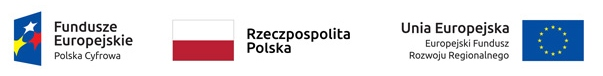</center>